<a href="https://colab.research.google.com/github/j4m3su0/btc-returns-forecasting-LSTM/blob/main/BTC_Returns_Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Forecasting of Bitcoin Returns Using LSTM Neural Networks



*Riley Murray and James Onyegbosi*



---



## **0. Introduction**

Bitcoin is one of the most liquid and actively traded digital assets, making it a popular subject for quantitative trading research. Due to its high volatility and 24/7 trading environment, Bitcoin provides a rich dataset for applying machine learning techniques to financial forecasting problems.

Traditional time-series models often struggle to capture nonlinear relationships and long-range temporal dependencies present in financial data. LSTM networks, a class of recurrent neural networks designed to retain information across time, offer a potential advantage in this setting. Rather than relying on raw price data alone, this project employs a multivariate approach, incorporating technical indicators that capture trend, momentum, volatility, and volume dynamics.

The focus of this notebook is not only on predictive accuracy, but also on the practical implications of model forecasts in a trading context. By explicitly separating feature engineering, model training, and strategy evaluation, the project aims to provide a clear and reproducible framework for applying deep learning methods to quantitative trading problems.



---



## **1. Objectives**

The primary aim of this project is to develop and evaluate a multivariate LSTM-based time-series forecasting model for predicting short-horizon Bitcoin returns. Specifically, the project seeks to:

*   Engineer meaningful technical indicators from historical Bitcoin price and volume data.
*   Train an LSTM neural network to forecast next-period returns.
*   Evaluate the predictive performance of the model using standard error metrics and directional accuracy.
*   Demonstrate how model predictions can be translated into a simple quantitative trading strategy.



---



## **2. Imports and Setup**

In [1]:
# ===================================
# Core Numerical and Data Libraries
# ===================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =====================================
# Preprocessing and Metrics Libraries
# =====================================

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from scipy.stats import spearmanr

# =================================
# Warning Configuration Libraries
# =================================

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# =========================
# Deep Learning Libraries
# =========================

try:
    import tensorflow as tf
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    tf.random.set_seed(42)

except ImportError:
    print("Installing required libraries")
    import subprocess
    subprocess.check_call(['pip',
                           'install',
                           'tensorflow',
                           '--break-system-packages'])
    import tensorflow as tf
    from tensorflow import keras
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    tf.random.set_seed(42)

# ==========================
# Financial Data Libraries
# ==========================

try:
    import yfinance as yf
except ImportError:
    print("Installing yfinance")
    import subprocess
    subprocess.check_call(['pip',
                           'install',
                           'yfinance',
                           '--break-system-packages'])
    import yfinance as yf

# ====================
# Plot Configuration
# ====================

plt.rcParams["figure.figsize"] = (12, 6)




---



## **3. Data Download and Basic Cleaning**

*   Download BTC-USD data
*   Handle missing rows
*   Plot price and volume


Data shape: (2556, 5)
Date range: 2019-01-01 00:00:00 to 2025-12-30 00:00:00

First few rows:
Price             Close         High          Low         Open      Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD     BTC-USD
Date                                                                      
2019-01-01  3843.520020  3850.913818  3707.231201  3746.713379  4324200990
2019-01-02  3943.409424  3947.981201  3817.409424  3849.216309  5244856836
2019-01-03  3836.741211  3935.685059  3826.222900  3931.048584  4530215219
2019-01-04  3857.717529  3865.934570  3783.853760  3832.040039  4847965467
2019-01-05  3845.194580  3904.903076  3836.900146  3851.973877  5137609824

Missing values per column:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

Missing values after cleaning: 0

Summary Statistics:
Price           Close           High            Low           Open  \
Ticker        BTC-

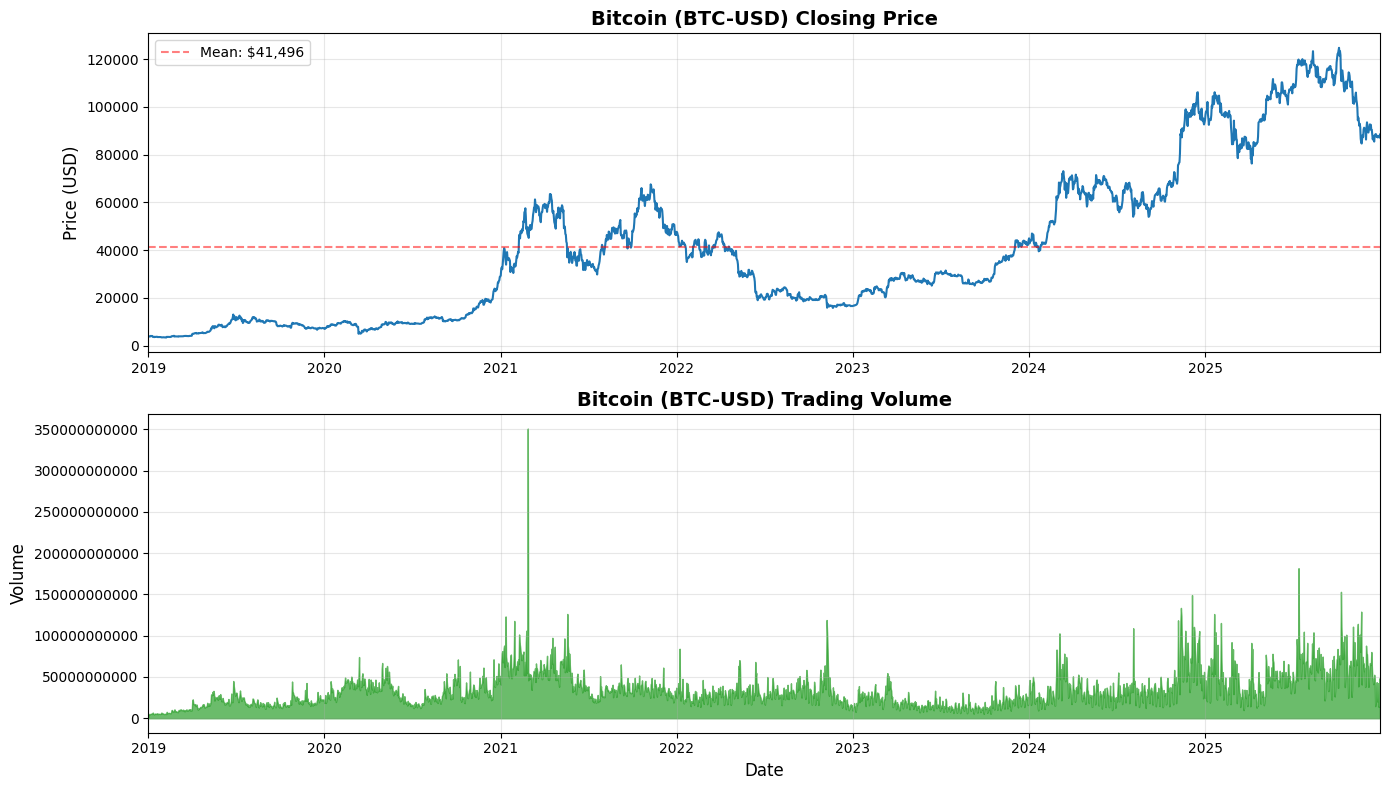


Price Statistics:
Maximum Price: $124,752.53
Minimum Price: $3,399.47
Mean Price: $41,495.65
Price Range: $121,353.06
Coefficient of Variation: 77.74%


In [2]:
# ==================================
# Data Download and Basic Cleaning
# ==================================

ticker = "BTC-USD"
start_date = "2019-01-01"
end_date = "2025-12-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)

print(f"\nData shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:")
print(df.head())

# ================================
# Check and Handle Missing Values
# =================================

print(f"\nMissing values per column:")
print(df.isnull().sum())

if df.isnull().sum().sum() > 0:
    df = df.ffill()

    if df.isnull().sum().sum() > 0:
        df = df.bfill()

print(f"\nMissing values after cleaning: {df.isnull().sum().sum()}")

print(f"\nSummary Statistics:")
print(df.describe())

# =================================
# Visualization: Price and Volume
# =================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

mean_price = float(df['Close'].mean())
max_price = float(df['Close'].max())
min_price = float(df['Close'].min())

# Plot 1: Closing Price
axes[0].plot(df.index, df['Close'], color='#1f77b4', linewidth=1.5)
axes[0].set_title('Bitcoin (BTC-USD) Closing Price', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(df.index.min(), df.index.max())

axes[0].axhline(mean_price, color='red', linestyle='--', alpha=0.5, label=f'Mean: ${mean_price:,.0f}')
axes[0].legend(loc='upper left')

# Plot 2: Trading Volume
volume_data = df['Volume'].values.flatten()
axes[1].fill_between(df.index, 0, volume_data, color='#2ca02c', alpha=0.7)
axes[1].set_title('Bitcoin (BTC-USD) Trading Volume', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volume', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(df.index.min(), df.index.max())

axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Additional price statistics
print(f"\n{'='*50}")
print("Price Statistics:")
print(f"{'='*50}")
print(f"Maximum Price: ${max_price:,.2f}")
print(f"Minimum Price: ${min_price:,.2f}")
print(f"Mean Price: ${mean_price:,.2f}")
print(f"Price Range: ${max_price - min_price:,.2f}")
print(f"Coefficient of Variation: {(float(df['Close'].std()) / float(df['Close'].mean()) * 100):.2f}%")




---



## **4. Feature Engineering**

*   Compute logarithmic returns
*   Compute other indicators (RSI, MACD, volatility, etc.)

### **Log Returns**

**Purpose**:
Transform non-stationary price levels into a stationary time series suitable for modelling.

**Definition**:
$$
r_t = \log(P_t) - \log(P_{t-1})
$$

**Interpretation**:
Log returns measure proportional price changes and fluctuate around zero, making them more amenable to statistical and machine learning models.


### **Relative Strength Index (RSI)**

**Purpose**:
Measure short-term momentum and identify overbought or oversold market conditions.

**Definition**:
$$
RSI_t = 100 - \frac{100}{1 + RS_t}
$$

$$
RS_t = \frac{\text{Average Gain}_t}{\text{Average Loss}_t}
$$

**Interpretation**:
*  RSI > 70 → overbought conditions
*  RSI < 30 → oversold conditions
*  RSI tends to exhibit mean-reverting behaviour


### **Moving Average Convergence Divergence (MACD)**

**Purpose**:
Capture trend-following momentum and changes in price direction.

**Definition**:
$$
\text{MACD}_t = \text{EMA}_{12}(P_t) - \text{EMA}_{26}(P_t)
$$
$$
\text{Signal}_t = \text{EMA}_{9}(\text{MACD}_t)
$$

**Interpretation**:
Positive MACD values indicate upward momentum, while crossovers between the MACD and signal line often signal trend changes.

### **Rolling Volatility of Log Returns**

**Purpose**:
Measure time-varying risk and volatility clustering in returns.

**Definition**:
$$
\sigma_t = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(r_{t-i} - \bar{r}\right)^2}
$$

where $r_t$ denotes log returns over a rolling window of length $n$.

**Interpretation**:
Volatility tends to cluster in financial markets, with high-volatility periods followed by high volatility and vice versa.

### **Percentage Change in Trading Volume**

**Purpose**:
Capture changes in market activity and participation.

**Definition**:
$$
\Delta V_t = \frac{V_t - V_{t-1}}{V_{t-1}}
$$

**Interpretation**:
Large positive values indicate sudden increases in trading activity, which often accompany or precede significant price movements.

Model dataset shape: (2501, 8)


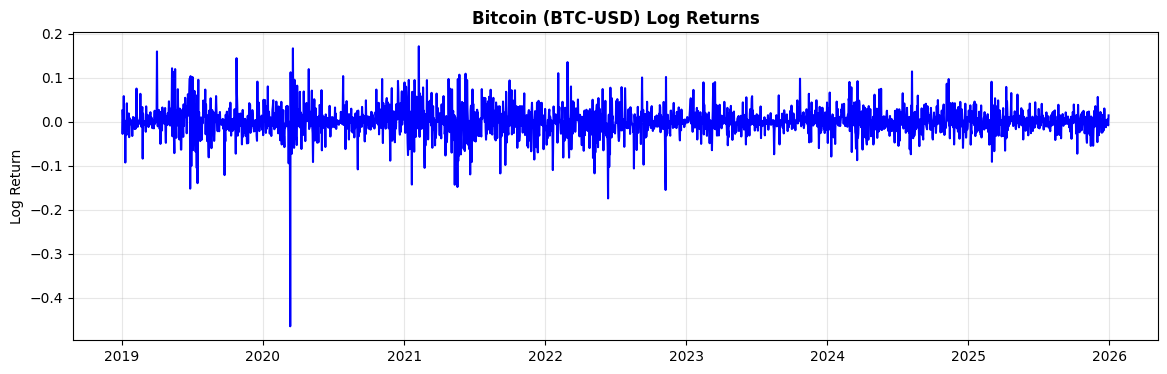

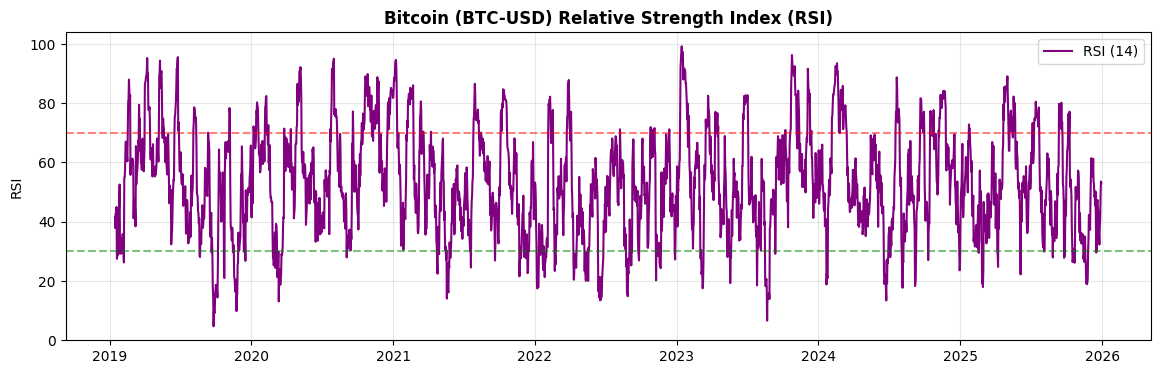

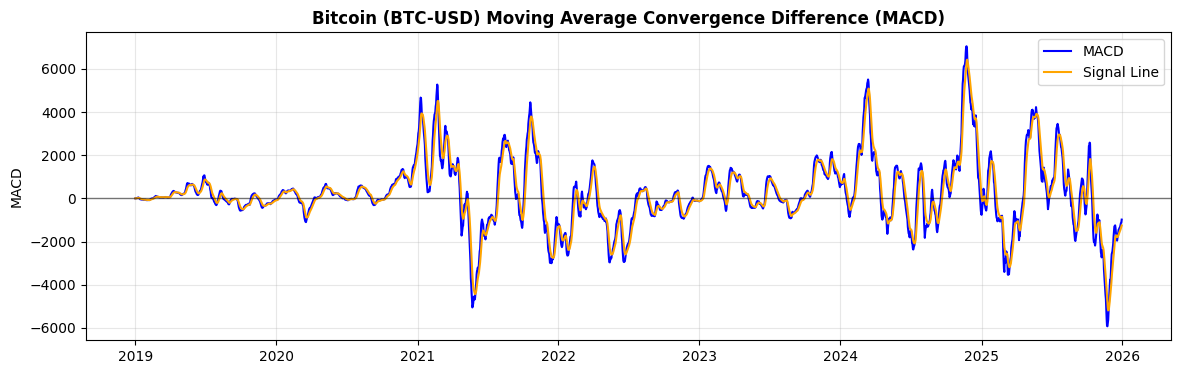

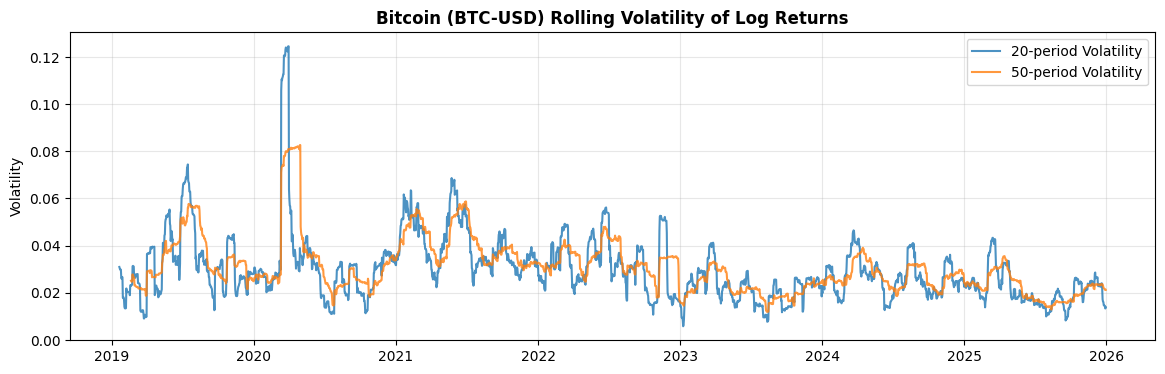

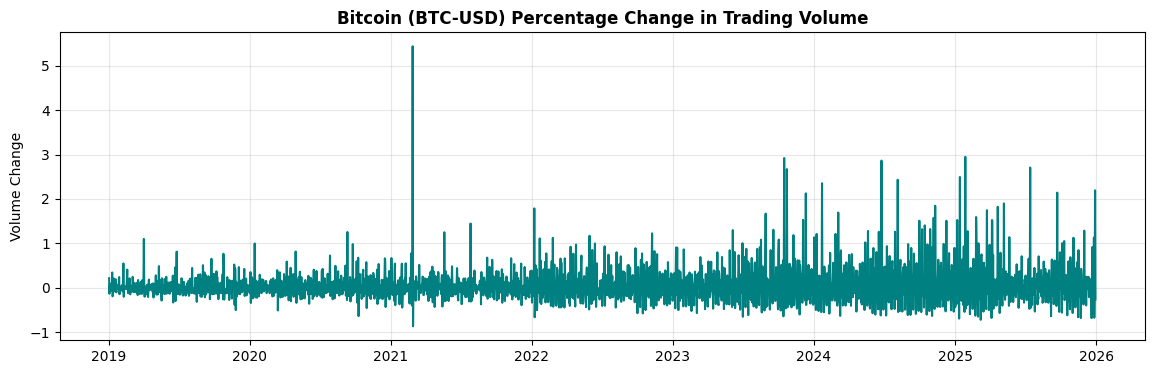

In [3]:

# ======================
# Computing Indicators
# ======================

# Computing logarithmic returns
df['log_return'] = np.log(df['Close']).diff()


# Computing RSI (14-period)
window = 14
delta = df['Close'].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()

rs = avg_gain / avg_loss
df['rsi'] = 100 - (100 / (1 + rs))

# Computing MACD
ema_fast = df['Close'].ewm(span=12, adjust=False).mean()
ema_slow = df['Close'].ewm(span=26, adjust=False).mean()

df['macd'] = ema_fast - ema_slow
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Computing rolling volatility of returns
df['volatility_20'] = df['log_return'].rolling(20).std()
df['volatility_50'] = df['log_return'].rolling(50).std()

# Computing target (5-day forward log return)
df['target'] = (
    df['log_return']
    .shift(-1)          # Start from next day
    .rolling(5)         # 5-day window
    .sum()              # Aggregate log returns
    .shift(-4)          # Align so target is truly "future"
)

feature_cols = [
    'log_return',
    'rsi',
    'macd',
    'macd_signal',
    'volatility_20',
    'volatility_50',
    'volume_change'
]

# Computing percentage change in volume
df['volume_change'] = df['Volume'].pct_change()

df_model = df[feature_cols + ['target']].dropna()

print(f"Model dataset shape: {df_model.shape}")

# ========================
# Visualising Indicators
# ========================

# Plotting logarithmic returns
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['log_return'], color='blue')
plt.title('Bitcoin (BTC-USD) Log Returns', fontweight='bold')
plt.ylabel('Log Return')
plt.grid(alpha=0.3)
plt.show()

# Plotting RSI
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['rsi'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.title('Bitcoin (BTC-USD) Relative Strength Index (RSI)', fontweight='bold')
plt.ylabel('RSI')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Plotting MACD
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['macd'], label='MACD', color='blue')
plt.plot(df.index, df['macd_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='black', linewidth=1, alpha=0.5)
plt.title('Bitcoin (BTC-USD) Moving Average Convergence Difference (MACD)', fontweight='bold')
plt.ylabel('MACD')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Plotting rolling vollatility (20-day and 50 day period)
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['volatility_20'], label='20-period Volatility', alpha=0.8)
plt.plot(df.index, df['volatility_50'], label='50-period Volatility', alpha=0.8)
plt.title('Bitcoin (BTC-USD) Rolling Volatility of Log Returns', fontweight='bold')
plt.ylabel('Volatility')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Plotting percentage change in volume
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['volume_change'], color='teal')
plt.title('Bitcoin (BTC-USD) Percentage Change in Trading Volume', fontweight='bold')
plt.ylabel('Volume Change')
plt.grid(alpha=0.3)
plt.show()




---



## **5. Training, Validation and Test Data Splitting**

*   Time-based split (no shuffling)
*   State your split dates clearly

In [4]:
train_end = '2023-12-31'
val_end   = '2024-12-31'

train_df = df_model.loc[:train_end]
val_df   = df_model.loc[train_end:val_end]
test_df  = df_model.loc[val_end:]

print("Train:", train_df.index.min(), "→", train_df.index.max(), train_df.shape)
print("Val:  ", val_df.index.min(), "→", val_df.index.max(), val_df.shape)
print("Test: ", test_df.index.min(), "→", test_df.index.max(), test_df.shape)


Train: 2019-02-20 00:00:00 → 2023-12-31 00:00:00 (1776, 8)
Val:   2023-12-31 00:00:00 → 2024-12-31 00:00:00 (367, 8)
Test:  2024-12-31 00:00:00 → 2025-12-25 00:00:00 (360, 8)




---



## **6. Scaling and Sequence Building**

In [5]:
# ==============================
# Separate Features and Target
# ==============================

X_train = train_df[feature_cols].values
y_train = train_df['target'].values

X_val = val_df[feature_cols].values
y_val = val_df['target'].values

X_test = test_df[feature_cols].values
y_test = test_df['target'].values

# =================
# Feature Scaling
# =================

scaler = MinMaxScaler(feature_range=(-1, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Set sequence length
SEQ_LEN = 50

# =================================
# Sequence Construction Functions
# =================================

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])

    return np.array(X_seq), np.array(y_seq)

# =================
# Build Sequences
# =================

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LEN)
X_val_seq, y_val_seq     = create_sequences(X_val_scaled, y_val, SEQ_LEN)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test, SEQ_LEN)

print("Train sequences:", X_train_seq.shape, y_train_seq.shape)
print("Val sequences:  ", X_val_seq.shape, y_val_seq.shape)
print("Test sequences: ", X_test_seq.shape, y_test_seq.shape)


Train sequences: (1726, 50, 7) (1726,)
Val sequences:   (317, 50, 7) (317,)
Test sequences:  (310, 50, 7) (310,)




---



## **7. Build LSTM Model**

In [6]:
y_train_seq = y_train_seq.reshape(-1, 1)
y_val_seq   = y_val_seq.reshape(-1, 1)
y_test_seq  = y_test_seq.reshape(-1, 1)

n_features = X_train_seq.shape[2]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, n_features), recurrent_dropout=0.1),
    Dropout(0.2),
    LSTM(32, recurrent_dropout=0.1),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,121 (121.57 KB)

 Trainable params: 31,121 (121.57 KB)

 Non-trainable params: 0 (0.00 B)



---



## **8. Model Training, Validation, Testing and Evaluation**

*  Evaluation metrics: MSE, MAE, directional accuracy, Spearman rank IC


### **Mean Square Error (MSE)**

**Purpose**:
Measure the average squared deviation between predicted and realised returns, penalising large forecast errors more heavily.

**Definition**:
$$
\mathrm{MSE} = \frac{1}{N} \sum_{t=1}^{N} \left( \hat{r}_t - r_t \right)^2
$$

**Interpretation**:
MSE provides a measure of point-wise forecasting accuracy. In financial return prediction, large MSE values are expected due to the high noise-to-signal ratio, and MSE is primarily used as a stability and convergence diagnostic rather than a trading performance metric.

Computing the MSE of validation and testing data gives us our validation and test loss respectively.

### **Mean Absolute Error (MAE)**

**Purpose**:
Measure the average magnitude of prediction errors in a scale-interpretable manner.

**Definition**:

$$
\mathrm{MAE} = \frac{1}{N} \sum_{t=1}^{N} \left| \hat{r}_t - r_t \right|
$$

**Interpretation**:
MAE represents the average absolute deviation between predicted and realised returns. Unlike MSE, MAE penalises all errors linearly and is easier to interpret in return units.

### **Directional Accuracy**

**Purpose**:
Assess whether the model correctly predicts the direction (sign) of future returns.

**Definition**:

$$
\mathrm{DA} = \frac{1}{N} \sum_{t=1}^{N}
\mathbb{1}\left[
\mathrm{sign}(\hat{r}_t) = \mathrm{sign}(r_t)
\right]
$$


where $\mathbb{1}[...]$ denotes the indicator function.

**Interpretation**:
Directional accuracy measures the proportion of times the model correctly predicts whether returns are positive or negative. Values close to $0.5$ correspond to random guessing, while values modestly above $0.5$ may indicate economically meaningful predictive structure.

### **Spearman Rank Information Coefficient (IC)**

**Purpose**:
Evaluate the strength of the monotonic relationship between predicted and realised returns.

**Definition**:

$$
\mathrm{IC} = \rho_s\left(\hat{r}_t, r_t\right)
$$

where $\rho_s(...,...)$ denotes the Spearman rank correlation coefficient.

**Interpretation**:
The Spearman IC measures whether higher predicted returns tend to correspond to higher realised returns, regardless of scale. Even small positive IC values (e.g. 0.01–0.03) may indicate useful predictive signals when combined with appropriate portfolio construction and risk management.

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 0.0071 - mae: 0.0586 - val_loss: 0.0038 - val_mae: 0.0486 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0068 - mae: 0.0568 - val_loss: 0.0038 - val_mae: 0.0484 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.0068 - mae: 0.0563 - val_loss: 0.0038 - val_mae: 0.0485 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0068 - mae: 0.0565 - val_loss: 0.0038 - val_mae: 0.0485 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0067 - mae: 0.0562 - val_loss: 0.0038 - val_mae: 0.0489 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0068 - mae: 0.0565 - val_loss: 0.0038 - val_mae: 0.0484 - learning_rate: 0.0010
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0067 - mae: 0.0560 - val_loss: 0.0038 - val_mae: 0.0486 - learning_rate: 5.0000

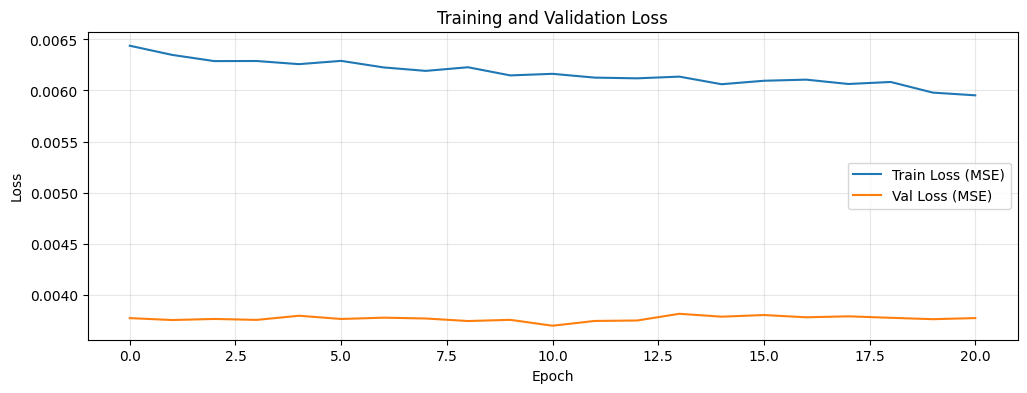

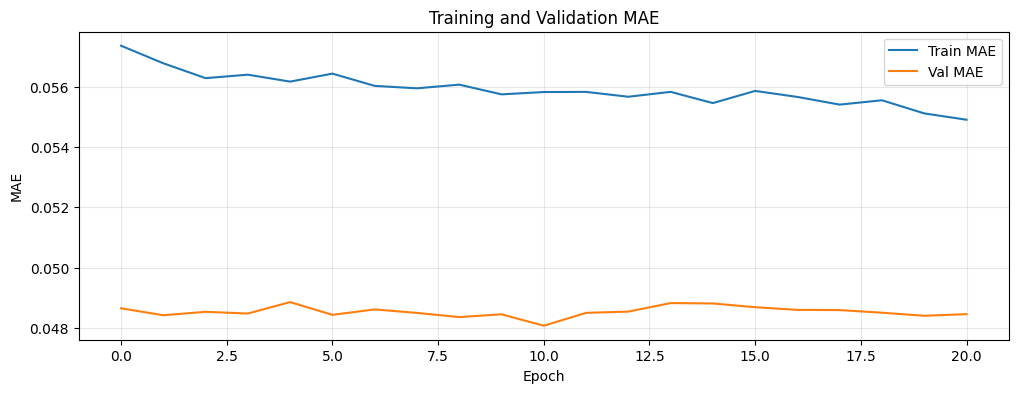

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

Validation Results
------------------
MSE: 0.003697
MAE: 0.048068
Directional Accuracy: 0.5079
Spearman IC: 0.0835


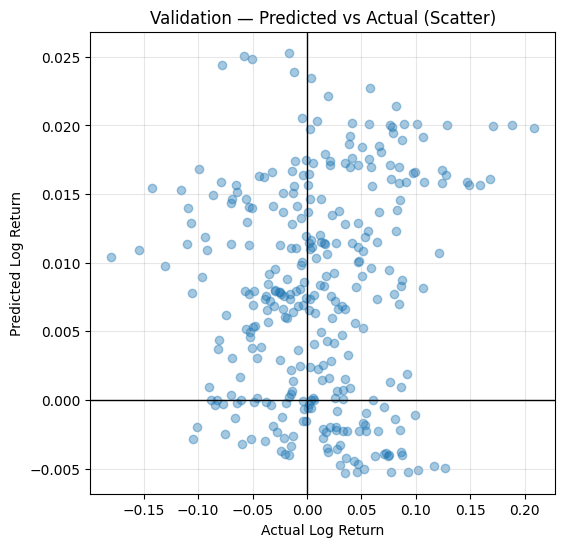

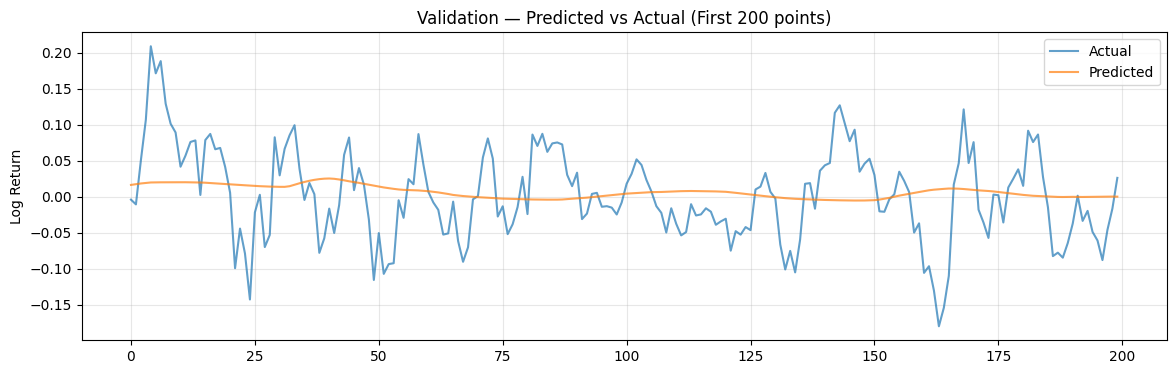

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Test Results
------------
MSE: 0.002184
MAE: 0.036125
Directional Accuracy: 0.5032
Spearman IC: 0.0015


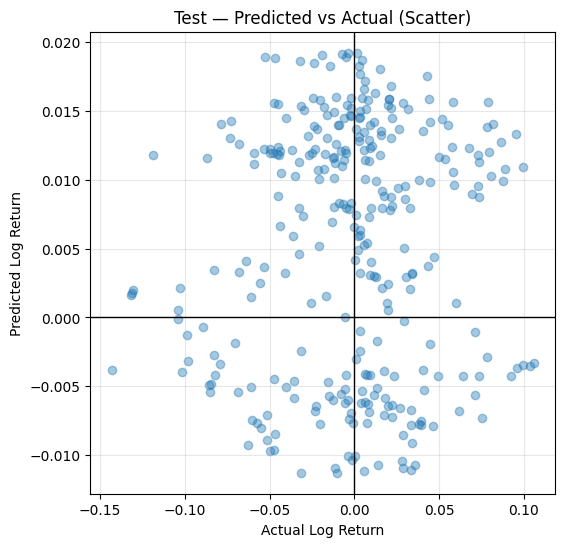

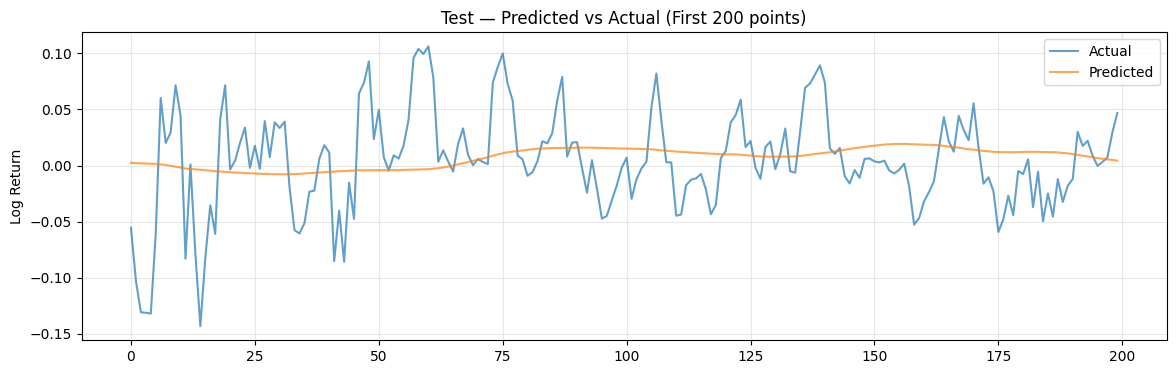

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# =======================
# Plot Training History
# =======================

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# ======================
# Evaluation Functions
# ======================

def evaluate_predictions(y_true, y_pred, name=""):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    da  = np.mean(np.sign(y_true) == np.sign(y_pred))
    ic  = spearmanr(y_true, y_pred).correlation

    print(f"\n{name} Results")
    print("-" * (len(name) + 8))
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"Directional Accuracy: {da:.4f}")
    print(f"Spearman IC: {ic:.4f}")

    return mse, mae, da, ic


def plot_pred_vs_actual(y_true, y_pred, title="", n_plot=200):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Scatter: predicted vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.4)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.xlabel('Actual Log Return')
    plt.ylabel('Predicted Log Return')
    plt.title(f'{title} — Predicted vs Actual (Scatter)')
    plt.grid(alpha=0.3)
    plt.show()

    # Time-series window
    plt.figure(figsize=(14, 4))
    plt.plot(y_true[:n_plot], label='Actual', alpha=0.7)
    plt.plot(y_pred[:n_plot], label='Predicted', alpha=0.7)
    plt.title(f'{title} — Predicted vs Actual (First {n_plot} points)')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Validation evaluation
val_pred = model.predict(X_val_seq).flatten()
evaluate_predictions(y_val_seq, val_pred, name="Validation")
plot_pred_vs_actual(y_val_seq, val_pred, title="Validation", n_plot=200)

# Test evaluation
test_pred = model.predict(X_test_seq).flatten()
evaluate_predictions(y_test_seq, test_pred, name="Test")
plot_pred_vs_actual(y_test_seq, test_pred, title="Test", n_plot=200)





---



## **9. Trading Strategy Implementation**

This section translates model predictions into actionable trading signals and
evaluates the performance of a simple long-short strategy based on predicted
returns.

Strategy Logic:
- If predicted return > threshold: LONG position
- If predicted return < -threshold: SHORT position
- Otherwise: No position (flat)

Performance metrics include cumulative returns, Sharpe ratio, maximum drawdown,
and win rate.

Chosen long threshold: 0.01289085
Chosen short threshold: 0.0016051971

Signal Distribution
Long positions:  77 (24.8%)
Short positions: 111 (35.8%)
Flat positions:  122 (39.4%)

Conditional Performance (Active Days Only)
Participation rate: 60.65%
Win rate (active days): 50.53%

PERFORMANCE COMPARISON (Test Set)
Metric                           LSTM Strategy           Buy & Hold
----------------------------------------------------------------------
Total Return                            80.83%              -38.91%
Sharpe Ratio                             1.041               -0.663
Max Drawdown                           -59.75%              -83.08%
Win Rate                                30.65%               52.58%
Avg Win                               0.036486             0.031213
Avg Loss                             -0.029324            -0.037963
Number of Periods                          310                  310



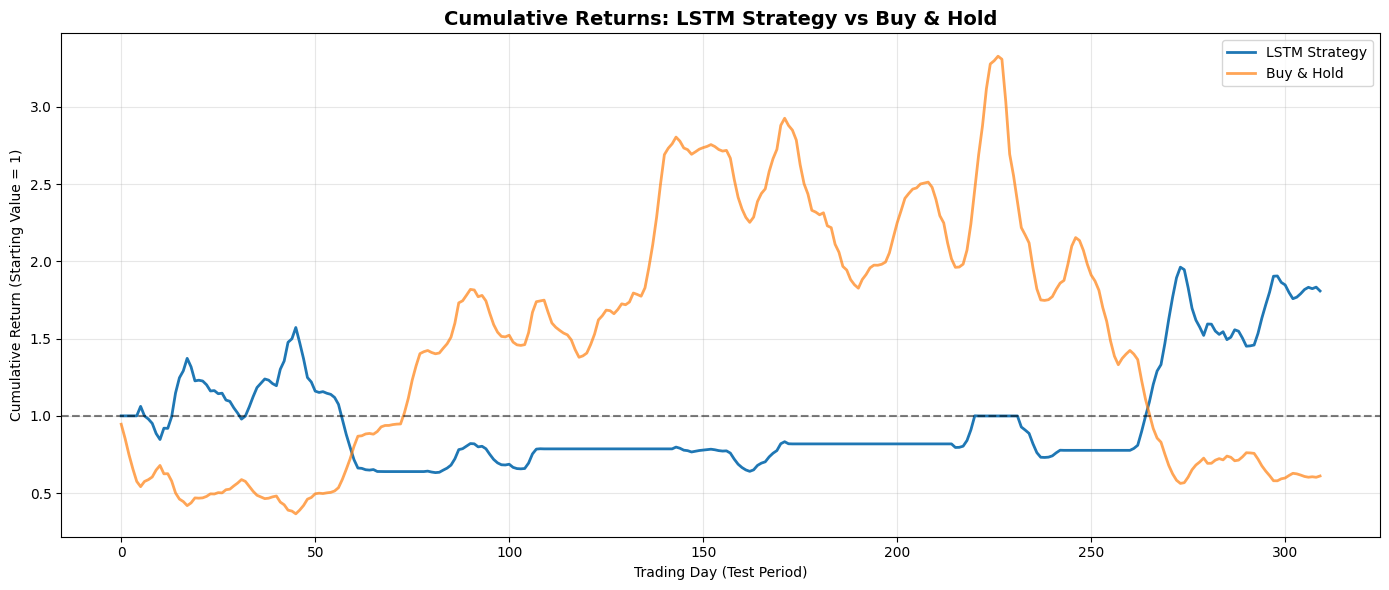

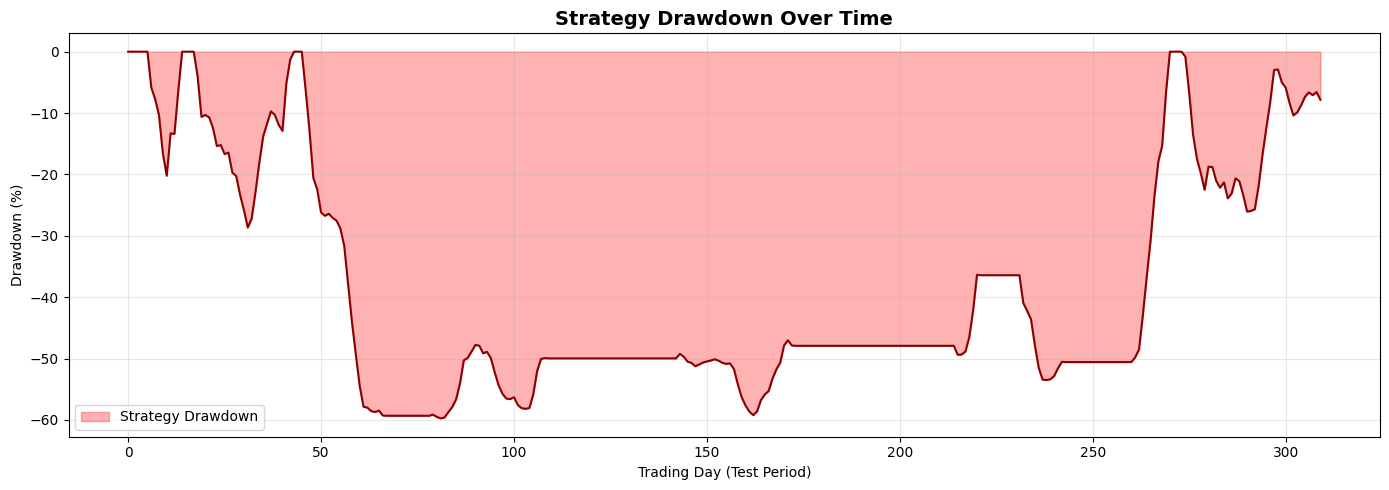

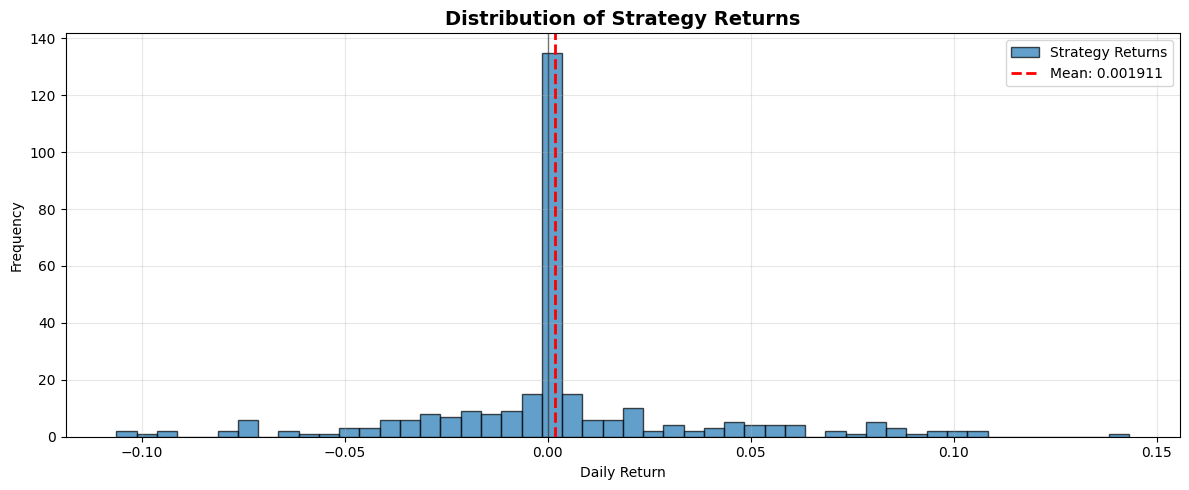

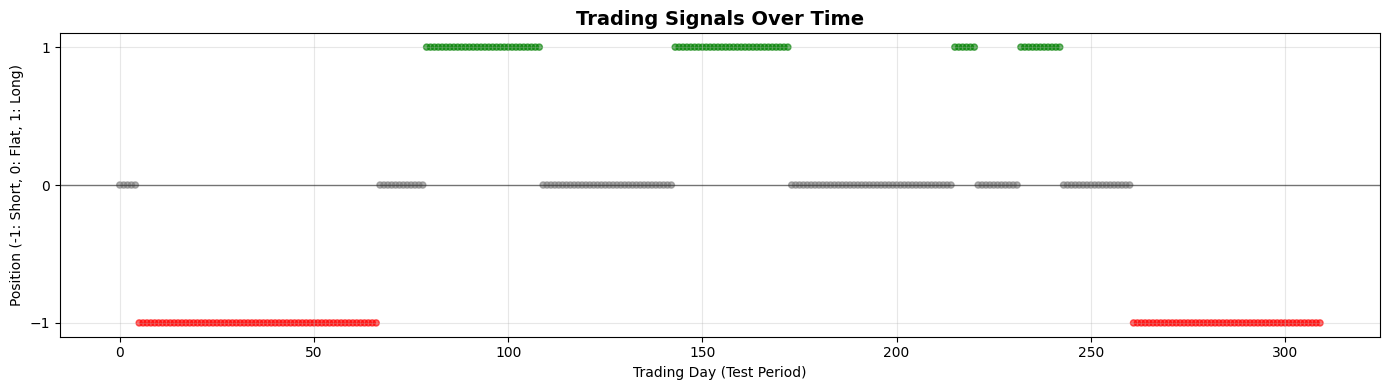


Returns by Signal Type

Long Positions:
  Count: 77
  Mean Return: 0.002581
  Win Rate: 54.55%
  Total Return: 21.98%

Short Positions:
  Count: 111
  Mean Return: 0.003592
  Win Rate: 47.75%
  Total Return: 48.99%

Transaction Cost Impact
Gross Return: 82.83%
Total Costs:  1.10%
Net Return:   80.83%
Cost Impact:  1.82% of gross returns


In [8]:

# =====================
# Strategy Parameters
# =====================

# SIGNAL_THRESHOLD = 0.001

"""
# Single threshold for long psoitions
q = 0.70  # Will trade only top 30% strongest signals
SIGNAL_THRESHOLD = np.quantile(np.abs(val_pred), q)
print("Chosen threshold:", SIGNAL_THRESHOLD)
"""

# Asymmetric threshold
long_th  = np.quantile(val_pred, 0.70)  # Will trade only top 30% strongest signals for long position
short_th = np.quantile(val_pred, 0.30)  # Will trade only top 30% strongest signals for short position
print("Chosen long threshold:", long_th)
print("Chosen short threshold:", short_th)

TRANSACTION_COST = 0.001

# ==========================
# Generate Trading Signals
# ==========================

"""
def generate_signals(predictions, threshold=SIGNAL_THRESHOLD):
    signals = np.zeros(len(predictions))
    signals[predictions > threshold] = 1
    signals[predictions < -threshold] = -1
    return signals

test_signals = generate_signals(test_pred, threshold=SIGNAL_THRESHOLD)
"""

def generate_signals_asym(pred, long_th, short_th):
    s = np.zeros(len(pred))
    s[pred > long_th] = 1
    s[pred < short_th] = -1
    return s

test_signals = generate_signals_asym(test_pred, long_th, short_th)


print(f"\n{'='*50}")
print("Signal Distribution")
print(f"{'='*50}")
print(f"Long positions:  {np.sum(test_signals == 1)} ({np.sum(test_signals == 1)/len(test_signals)*100:.1f}%)")
print(f"Short positions: {np.sum(test_signals == -1)} ({np.sum(test_signals == -1)/len(test_signals)*100:.1f}%)")
print(f"Flat positions:  {np.sum(test_signals == 0)} ({np.sum(test_signals == 0)/len(test_signals)*100:.1f}%)")

# ============================
# Calculate Strategy Returns
# ============================

def calculate_strategy_returns(signals, actual_returns, transaction_cost=TRANSACTION_COST):
    position_changes = np.abs(np.diff(signals, prepend=0))

    gross_returns = signals * actual_returns.flatten()

    costs = position_changes * transaction_cost
    strategy_returns = gross_returns - costs

    return strategy_returns, gross_returns, costs

strategy_returns, gross_returns, costs = calculate_strategy_returns(
    test_signals,
    y_test_seq,
    transaction_cost=TRANSACTION_COST
)

# ================================================
# Conditional Win Rate (when strategy is active)
# ================================================

active = test_signals != 0  # Days when you hold a position

participation_rate = np.mean(active)
win_rate_active = np.mean(strategy_returns[active] > 0) if np.any(active) else np.nan

print(f"\n{'='*50}")
print("Conditional Performance (Active Days Only)")
print(f"{'='*50}")
print(f"Participation rate: {participation_rate*100:.2f}%")
print(f"Win rate (active days): {win_rate_active*100:.2f}%")

buy_hold_returns = y_test_seq.flatten()

# ================================
# Calculate Performance Metrics
# ================================

def calculate_performance_metrics(returns, label="Strategy"):

    cumulative_return = np.exp(np.sum(returns)) - 1
    total_return_pct = cumulative_return * 100

    mean_return = np.mean(returns)
    std_return = np.std(returns)

    sharpe = (mean_return / std_return) * np.sqrt(365) if std_return > 0 else 0   # Bitcoin trades for 365 days, not 252

    cumulative = np.exp(np.cumsum(returns))
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = np.min(drawdown)

    win_rate = np.mean(returns > 0) if len(returns) > 0 else 0

    wins = returns[returns > 0]
    losses = returns[returns < 0]
    avg_win = np.mean(wins) if len(wins) > 0 else 0
    avg_loss = np.mean(losses) if len(losses) > 0 else 0

    metrics = {
        'label': label,
        'total_return': total_return_pct,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown * 100,
        'win_rate': win_rate * 100,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'num_trades': len(returns)  # This computes the number of trading periods, not the number of trades i.e. num_trades = np.sum(np.abs(np.diff(test_signals)) > 0)

    }

    return metrics

strategy_metrics = calculate_performance_metrics(strategy_returns, "LSTM Strategy")
buyhold_metrics = calculate_performance_metrics(buy_hold_returns, "Buy & Hold")

# ================================
# Display Performance Comparison
# ================================

print(f"\n{'='*70}")
print("PERFORMANCE COMPARISON (Test Set)")
print(f"{'='*70}")
print(f"{'Metric':<25} {'LSTM Strategy':>20} {'Buy & Hold':>20}")
print(f"{'-'*70}")
print(f"{'Total Return':<25} {strategy_metrics['total_return']:>19.2f}% {buyhold_metrics['total_return']:>19.2f}%")
print(f"{'Sharpe Ratio':<25} {strategy_metrics['sharpe_ratio']:>20.3f} {buyhold_metrics['sharpe_ratio']:>20.3f}")
print(f"{'Max Drawdown':<25} {strategy_metrics['max_drawdown']:>19.2f}% {buyhold_metrics['max_drawdown']:>19.2f}%")
print(f"{'Win Rate':<25} {strategy_metrics['win_rate']:>19.2f}% {buyhold_metrics['win_rate']:>19.2f}%")
print(f"{'Avg Win':<25} {strategy_metrics['avg_win']:>20.6f} {buyhold_metrics['avg_win']:>20.6f}")
print(f"{'Avg Loss':<25} {strategy_metrics['avg_loss']:>20.6f} {buyhold_metrics['avg_loss']:>20.6f}")
print(f"{'Number of Periods':<25} {strategy_metrics['num_trades']:>20} {buyhold_metrics['num_trades']:>20}")
print(f"{'='*70}\n")

# ================================
# Visualize Strategy Performance
# ================================

strategy_cumulative = np.exp(np.cumsum(strategy_returns))
buyhold_cumulative = np.exp(np.cumsum(buy_hold_returns))

plt.figure(figsize=(14, 6))
plt.plot(strategy_cumulative, label='LSTM Strategy', linewidth=2)
plt.plot(buyhold_cumulative, label='Buy & Hold', linewidth=2, alpha=0.7)
plt.axhline(1, color='black', linestyle='--', alpha=0.5)
plt.title('Cumulative Returns: LSTM Strategy vs Buy & Hold', fontsize=14, fontweight='bold')
plt.xlabel('Trading Day (Test Period)')
plt.ylabel('Cumulative Return (Starting Value = 1)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

strategy_running_max = np.maximum.accumulate(strategy_cumulative)
strategy_drawdown = (strategy_cumulative - strategy_running_max) / strategy_running_max * 100

plt.figure(figsize=(14, 5))
plt.fill_between(range(len(strategy_drawdown)), strategy_drawdown, 0,
                 color='red', alpha=0.3, label='Strategy Drawdown')
plt.plot(strategy_drawdown, color='darkred', linewidth=1.5)
plt.title('Strategy Drawdown Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Trading Day (Test Period)')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(strategy_returns, bins=50, alpha=0.7, label='Strategy Returns', edgecolor='black')
plt.axvline(np.mean(strategy_returns), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {np.mean(strategy_returns):.6f}')
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
plt.title('Distribution of Strategy Returns', fontsize=14, fontweight='bold')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
colors = ['red' if s == -1 else 'green' if s == 1 else 'gray' for s in test_signals]
plt.scatter(range(len(test_signals)), test_signals, c=colors, alpha=0.6, s=20)
plt.axhline(0, color='black', linewidth=1, alpha=0.5)
plt.title('Trading Signals Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Trading Day (Test Period)')
plt.ylabel('Position (-1: Short, 0: Flat, 1: Long)')
plt.yticks([-1, 0, 1])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ========================================
# Additional Analysis: Returns by Signal
# ========================================

print(f"\n{'='*50}")
print("Returns by Signal Type")
print(f"{'='*50}")

long_returns = strategy_returns[test_signals == 1]
short_returns = strategy_returns[test_signals == -1]

if len(long_returns) > 0:
    print(f"\nLong Positions:")
    print(f"  Count: {len(long_returns)}")
    print(f"  Mean Return: {np.mean(long_returns):.6f}")
    print(f"  Win Rate: {np.mean(long_returns > 0)*100:.2f}%")
    print(f"  Total Return: {(np.exp(np.sum(long_returns)) - 1)*100:.2f}%")

if len(short_returns) > 0:
    print(f"\nShort Positions:")
    print(f"  Count: {len(short_returns)}")
    print(f"  Mean Return: {np.mean(short_returns):.6f}")
    print(f"  Win Rate: {np.mean(short_returns > 0)*100:.2f}%")
    print(f"  Total Return: {(np.exp(np.sum(short_returns)) - 1)*100:.2f}%")

# ================================
# Transaction Cost Impact Analysis
# ================================

print(f"\n{'='*50}")
print("Transaction Cost Impact")
print(f"{'='*50}")
print(f"Gross Return: {(np.exp(np.sum(gross_returns)) - 1)*100:.2f}%")
print(f"Total Costs:  {np.sum(costs)*100:.2f}%")
print(f"Net Return:   {(np.exp(np.sum(strategy_returns)) - 1)*100:.2f}%")
print(f"Cost Impact:  {(np.sum(costs) / np.sum(gross_returns))*100:.2f}% of gross returns")

## **10. Conclusion and Next Steps**

*   Talk about potential jump diffusion model implementation
HMM, GBM, Heston Model